In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
np.set_printoptions(suppress=True)

In [2]:
df = pd.read_csv('filtered_ratings.csv')
df.head()

,userId,movieId,rating
0,30561,121,3.5
1,30561,589,3.5
2,30561,20,3.5
3,30561,19,3.5
4,30561,13,3.5


In [3]:
N = df['userId'].nunique()
M = df['movieId'].nunique()

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=0)
X_train = np.array(train.iloc[:,0:2].values, dtype='int64')
y_train = train.iloc[:,2].values
X_test = np.array(test.iloc[:,0:2].values, dtype='int64')
y_test = test.iloc[:,2].values
if train['userId'].nunique()!=N or train['movieId'].nunique()!=M:
    print("change random state")

In [5]:
userids = np.array(train['userId'])
itemids = np.array(train['movieId'])
ratings = np.array(train['rating'])
csr_df = sparse.csr_matrix((ratings, (userids, itemids)), shape=(N,M))
csc_df = sparse.csc_matrix((ratings, (userids, itemids)), shape=(N,M))

In [6]:
K = 10  #latent dimension
W = np.random.rand(N, K)  #User feature Matrix
U = np.random.rand(M, K)  #Item feature Matrix
B = np.random.rand(N)     #User bias
C = np.random.rand(M)     #Item bias
g = ratings.mean()        #average rating on training dataset

In [7]:
def single_pred(i, j):
    return np.dot(W[i],U[j])+B[i]+C[j]+g

In [8]:
epochs = 15
train_loss, test_loss = [], []
print("Starting", datetime.now())
for epoch in range(epochs):
    for i in range(N):
        try:
            items = csr_df.getrow(i).indices
            u = U[items,:].reshape(-1, K, 1)
            a = np.sum(np.matmul(u, np.transpose(u, axes=[0,2,1])), 0)
            b = np.sum(np.multiply(U[items,:], (csr_df.getrow(i).data-B[i]-C[items]-g).reshape(-1, 1)), 0)
            W[i] = np.linalg.solve(a,b)
        except :
            continue
    for i in range(N):
        items = csr_df.getrow(i).indices
        B[i] = np.sum(csr_df.getrow(i).data-np.matmul(U[items,:], W[i])-C[items]-g)/float(csr_df.getrow(i).nnz)
    for j in range(M):
        try:
            users = csc_df.getcol(j).indices
            w = W[users,:].reshape(-1, K, 1)
            a = np.sum(np.matmul(w, np.transpose(w, axes=[0,2,1])), 0)
            b = np.sum(np.multiply(W[users,:], (csc_df.getcol(j).data-B[users]-C[j]-g).reshape(-1, 1)), 0)
            U[j] = np.linalg.solve(a,b)
        except:
            continue
    for j in range(M):
        users = csc_df.getcol(j).indices
        C[j] = np.sum(csc_df.getcol(j).data-np.matmul(W[users,:], U[j])-B[users]-g)/float(csc_df.getcol(j).nnz)
    
    train_loss.append(mse(y_train, np.sum(W[X_train[:,0]]*U[X_train[:,1]], axis=1)+B[X_train[:,0]]+C[X_train[:,1]]+g))
    test_loss.append(mse(y_test, np.sum(W[X_test[:,0]]*U[X_test[:,1]], axis=1)+B[X_test[:,0]]+C[X_test[:,1]]+g))
    print(datetime.now(), epoch+1, train_loss[-1], test_loss[-1])

Starting 2023-06-15 18:00:56.335357
2023-06-15 18:02:05.714268 1 0.7184174129695878 0.8166448563295918
2023-06-15 18:03:16.243623 2 0.6123572008080563 0.723462927744722
2023-06-15 18:04:25.596299 3 0.5640526937603646 0.6726344882283687
2023-06-15 18:05:37.589351 4 0.5438194207543064 0.6509580880025989
2023-06-15 18:06:48.254535 5 0.5345833328828674 0.6402147551858242
2023-06-15 18:07:59.980378 6 0.5288719926730628 0.6328363100582269
2023-06-15 18:09:12.583502 7 0.524891731680508 0.62731255720649
2023-06-15 18:10:24.224120 8 0.5220986166318958 0.6232832304004254
2023-06-15 18:11:34.460850 9 0.5201536296498556 0.6204281831688373
2023-06-15 18:12:46.256100 10 0.5187758996588208 0.6184267273590731
2023-06-15 18:13:57.264908 11 0.5177629124724772 0.6170157343596495
2023-06-15 18:15:08.466567 12 0.5169853134722618 0.6159992224134475
2023-06-15 18:16:20.193183 13 0.5163640033273493 0.6152385717717244
2023-06-15 18:17:31.925842 14 0.5158500600802525 0.6146446547641907
2023-06-15 18:18:44.54363

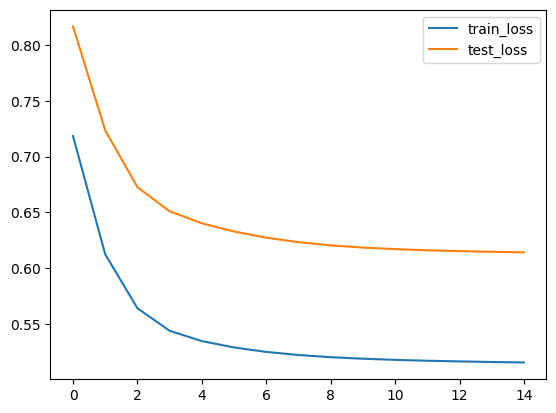

In [9]:
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()
plt.show()